In [3]:
from datasets import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import json

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------- Preprocesing Functions ----------
def preprocess_paradetox_multilingual(example):
    return {
        "input_text": "detoxify: " + example["toxic_sentence"],
        "target_text": example["neutral_sentence"]
    }

def preprocess_paradetox(example):
    return {
        "input_text": "detoxify: " + example["en_toxic_comment"],
        "target_text": example["en_neutral_comment"]
    }

def clean_columns(dataset):
    return dataset.remove_columns(
        [col for col in dataset.column_names if col not in ["input_text", "target_text"]]
    )


def load_json_results(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


def save_variables_to_json(filename, **variables):
    """
    Saves given variables to a JSON file with their variable names as keys.

    Parameters:
    - filename (str): The name of the JSON file to write to.
    - **variables: Arbitrary keyword arguments representing variable names and their values.
    """
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(variables, f, ensure_ascii=False, indent=2)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
# ---------- Load and Process Datasets ----------
test_data_en = load_dataset("textdetox/multilingual_paradetox", split="en")
test_data_de = load_dataset("textdetox/multilingual_paradetox", split="de")
train_data = load_dataset("s-nlp/paradetox", split="train") 

In [5]:
import re

formatted_train = clean_columns(train_data.map(preprocess_paradetox))
formatted_en = clean_columns(test_data_en.map(preprocess_paradetox_multilingual))
formatted_de = clean_columns(test_data_de.map(preprocess_paradetox_multilingual))


def remove_emojis(text):
    # This regex pattern matches a wide range of emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def clean_emoji_batch(batch):
    batch["input_text"] = remove_emojis(batch["input_text"])
    batch["target_text"] = remove_emojis(batch["target_text"])
    return batch

formatted_train = formatted_train.map(clean_emoji_batch)
formatted_en = formatted_en.map(clean_emoji_batch)
formatted_de = formatted_de.map(clean_emoji_batch)


In [6]:
print("Test dataset en size:", len(formatted_en))
print("Test dataset de size:", len(formatted_de))
print("Train dataset size:", len(formatted_train))

print("Test en dataset columns:", formatted_en.column_names)
print("Test de dataset columns:", formatted_de.column_names)
print("Train dataset columns:", formatted_train.column_names)

Test dataset en size: 400
Test dataset de size: 400
Train dataset size: 19744
Test en dataset columns: ['input_text', 'target_text']
Test de dataset columns: ['input_text', 'target_text']
Train dataset columns: ['input_text', 'target_text']


In [7]:
save_variables_to_json(
    "formatted_de.json",
    input_texts=formatted_de["input_text"],
    reference_texts=formatted_de["target_text"],
)

save_variables_to_json(
    "formatted_en.json",
    input_texts=formatted_en["input_text"],
    reference_texts=formatted_en["target_text"],
)

save_variables_to_json(
    "formatted_train.json",
    input_texts=formatted_train["input_text"],
    reference_texts=formatted_train["target_text"],
)

In [8]:
def tokenize(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=128,
        padding="max_length",
        truncation=True
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=128,
            padding="max_length",
            truncation=True
        )

    # Mask padding tokens in labels
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label_seq]
        for label_seq in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize dataset
tokenized_dataset = formatted_train.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.filter(lambda x: any(label != -100 for label in x["labels"]))

tokenized_eval = formatted_en.map(tokenize, batched=True)
tokenized_eval = tokenized_eval.filter(lambda x: any(label != -100 for label in x["labels"]))

# Assign to eval_dataset
eval_dataset = tokenized_eval
train_dataset = tokenized_dataset

In [9]:
print("Train dataset size:", len(train_dataset))
print("Eval dataset size:", len(eval_dataset))

Train dataset size: 19744
Eval dataset size: 400


In [ ]:
from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
    RobertaTokenizer
)
import torch
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_refined",
    report_to="none"
)

# ✅ Custom Trainer with full-batch penalty, lambda warmup, and logging
class ToxicityPenaltyTrainer(Seq2SeqTrainer):
    def __init__(self, *args, lambda_penalty=1.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_penalty = lambda_penalty
        self.tox_tokenizer = RobertaTokenizer.from_pretrained("unitary/toxic-bert")
        self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
        self.tox_model.eval()
        self.current_step = 0  # For lambda warmup
        self.penalty_log = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        generation_loss = outputs.loss

        # Full batch generation for penalty
        sample_input_ids = inputs["input_ids"]
        sample_attention_mask = inputs["attention_mask"]

        self.current_step += 1
        warmup_steps = 500
        current_lambda = min(self.lambda_penalty, self.lambda_penalty * self.current_step / warmup_steps)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                max_length=30,
                num_beams=4, 
                do_sample=False,
                early_stopping=True,
                decoder_start_token_id=self.tokenizer.pad_token_id
            )

            decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            tox_inputs = self.tox_tokenizer(decoded_texts, return_tensors="pt", truncation=True, padding=True).to(self.model.device)
            tox_logits = self.tox_model(**tox_inputs).logits
            tox_probs = torch.sigmoid(tox_logits[:, 0])
            penalty = tox_probs.mean()

        # Log penalty score
        self.log({"penalty_score": penalty.item()})
        self.penalty_log.append({
            "penalty_score": penalty.item(),
            "generation_loss": generation_loss.item(),
            "step": self.state.global_step,
            "epoch": self.state.epoch
        })

        # Scaled penalty
        penalty_weight = torch.tanh(current_lambda * penalty)
        total_loss = generation_loss + penalty_weight
        return (total_loss, outputs) if return_outputs else total_loss

# ✅ Instantiate and train
trainer = ToxicityPenaltyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    lambda_penalty=0.9
)

trainer.train()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [42]:
from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
    RobertaTokenizer
)
import torch
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Ensure decoder start token is set
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.pad_token_id

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Training arguments with label smoothing and higher batch size
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=12,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_refined",
    report_to="none",
    label_smoothing_factor=0.1
)

# Custom Trainer
class ToxicityPenaltyTrainer(Seq2SeqTrainer):
    def __init__(self, *args, lambda_penalty=1.5, penalty_interval=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_penalty = lambda_penalty
        self.penalty_interval = penalty_interval
        self.tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
        self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
        self.tox_model.eval()
        self.current_step = 0
        self.penalty_log = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        generation_loss = outputs.loss

        self.current_step += 1
        warmup_steps = 500
        current_lambda = self.lambda_penalty * min(1.0, (self.current_step / warmup_steps)) ** 0.7

        if self.current_step % self.penalty_interval == 0:
            with torch.no_grad():
                generated_ids = model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_length=30,
                    num_beams=1,
                    do_sample=False,
                    early_stopping=False,
                    decoder_start_token_id=self.tokenizer.pad_token_id
                )

                decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                tox_inputs = self.tox_tokenizer(
                    decoded_texts,
                    return_tensors="pt",
                    truncation=True,
                    padding=True
                ).to(self.model.device)

                tox_logits = self.tox_model(**tox_inputs).logits
                tox_probs = torch.sigmoid(tox_logits[:, 0])
                penalty = tox_probs.mean()
        else:
            penalty = torch.tensor(0.0, device=self.model.device)

        self.log({"penalty_score": penalty.item()})
        self.penalty_log.append({
            "penalty_score": penalty.item(),
            "generation_loss": generation_loss.item(),
            "step": self.state.global_step,
            "epoch": self.state.epoch
        })

        total_loss = generation_loss + current_lambda * penalty
        return (total_loss, outputs) if return_outputs else total_loss

if isinstance(train_dataset, dict):
    train_dataset = Dataset.from_dict(train_dataset)

train_dataset = train_dataset.select(range(min(500, len(train_dataset))))

training_args.generation_num_beams = max(training_args.generation_num_beams or 1, 2)


# Instantiate and train
trainer = ToxicityPenaltyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    lambda_penalty=1.5
)

trainer.train()


  0%|          | 0/63 [00:00<?, ?it/s]

{'penalty_score': 0.555883526802063, 'epoch': 0}
{'penalty_score': 0.5605634450912476, 'epoch': 0}
{'penalty_score': 0.4231046140193939, 'epoch': 0.05}
{'penalty_score': 0.34680747985839844, 'epoch': 0.05}
{'penalty_score': 0.3888695240020752, 'epoch': 0.1}
{'penalty_score': 0.48942071199417114, 'epoch': 0.1}
{'penalty_score': 0.39081311225891113, 'epoch': 0.14}
{'penalty_score': 0.3977140784263611, 'epoch': 0.14}
{'penalty_score': 0.47655218839645386, 'epoch': 0.19}
{'penalty_score': 0.495460569858551, 'epoch': 0.19}
{'penalty_score': 0.529101550579071, 'epoch': 0.24}
{'penalty_score': 0.4742964208126068, 'epoch': 0.24}
{'penalty_score': 0.4373147189617157, 'epoch': 0.29}
{'penalty_score': 0.4607536494731903, 'epoch': 0.29}
{'penalty_score': 0.28628218173980713, 'epoch': 0.33}
{'penalty_score': 0.23387323319911957, 'epoch': 0.33}
{'penalty_score': 0.5982010364532471, 'epoch': 0.38}
{'penalty_score': 0.2217162549495697, 'epoch': 0.38}
{'penalty_score': 0.41766858100891113, 'epoch': 0.4

  0%|          | 0/50 [00:00<?, ?it/s]

{'penalty_score': 0.9228119850158691, 'epoch': 1.0}
{'penalty_score': 0.6731896996498108, 'epoch': 1.0}
{'penalty_score': 0.7940024733543396, 'epoch': 1.0}
{'penalty_score': 0.76750648021698, 'epoch': 1.0}
{'penalty_score': 0.6206769943237305, 'epoch': 1.0}
{'penalty_score': 0.8514363765716553, 'epoch': 1.0}
{'penalty_score': 0.7414578795433044, 'epoch': 1.0}
{'penalty_score': 0.6562522649765015, 'epoch': 1.0}
{'penalty_score': 0.5680819153785706, 'epoch': 1.0}
{'penalty_score': 0.7369719743728638, 'epoch': 1.0}
{'penalty_score': 0.8076788187026978, 'epoch': 1.0}
{'penalty_score': 0.7547599673271179, 'epoch': 1.0}
{'penalty_score': 0.9661616086959839, 'epoch': 1.0}
{'penalty_score': 0.5344451069831848, 'epoch': 1.0}
{'penalty_score': 0.7508401870727539, 'epoch': 1.0}
{'penalty_score': 0.7598304748535156, 'epoch': 1.0}
{'penalty_score': 0.8688255548477173, 'epoch': 1.0}
{'penalty_score': 0.9647025465965271, 'epoch': 1.0}
{'penalty_score': 0.9667025804519653, 'epoch': 1.0}
{'penalty_scor

  0%|          | 0/50 [00:00<?, ?it/s]

{'penalty_score': 0.9224598407745361, 'epoch': 2.0}
{'penalty_score': 0.6799827814102173, 'epoch': 2.0}
{'penalty_score': 0.7940024733543396, 'epoch': 2.0}
{'penalty_score': 0.7313555479049683, 'epoch': 2.0}
{'penalty_score': 0.5002901554107666, 'epoch': 2.0}
{'penalty_score': 0.8563486933708191, 'epoch': 2.0}
{'penalty_score': 0.7410316467285156, 'epoch': 2.0}
{'penalty_score': 0.794150710105896, 'epoch': 2.0}
{'penalty_score': 0.5680819153785706, 'epoch': 2.0}
{'penalty_score': 0.8543010950088501, 'epoch': 2.0}
{'penalty_score': 0.8076105117797852, 'epoch': 2.0}
{'penalty_score': 0.8774646520614624, 'epoch': 2.0}
{'penalty_score': 0.9661616086959839, 'epoch': 2.0}
{'penalty_score': 0.6475437879562378, 'epoch': 2.0}
{'penalty_score': 0.7508401870727539, 'epoch': 2.0}
{'penalty_score': 0.8072324395179749, 'epoch': 2.0}
{'penalty_score': 0.7592477202415466, 'epoch': 2.0}
{'penalty_score': 0.9517785310745239, 'epoch': 2.0}
{'penalty_score': 0.9663486480712891, 'epoch': 2.0}
{'penalty_sco

  0%|          | 0/50 [00:00<?, ?it/s]

{'penalty_score': 0.9224598407745361, 'epoch': 3.0}
{'penalty_score': 0.6799827814102173, 'epoch': 3.0}
{'penalty_score': 0.8452281951904297, 'epoch': 3.0}
{'penalty_score': 0.7631480097770691, 'epoch': 3.0}
{'penalty_score': 0.5002901554107666, 'epoch': 3.0}
{'penalty_score': 0.855959415435791, 'epoch': 3.0}
{'penalty_score': 0.74089515209198, 'epoch': 3.0}
{'penalty_score': 0.794150710105896, 'epoch': 3.0}
{'penalty_score': 0.5680819153785706, 'epoch': 3.0}
{'penalty_score': 0.8543010950088501, 'epoch': 3.0}
{'penalty_score': 0.8076105117797852, 'epoch': 3.0}
{'penalty_score': 0.8774646520614624, 'epoch': 3.0}
{'penalty_score': 0.9664589166641235, 'epoch': 3.0}
{'penalty_score': 0.7092185020446777, 'epoch': 3.0}
{'penalty_score': 0.8124908804893494, 'epoch': 3.0}
{'penalty_score': 0.8072324395179749, 'epoch': 3.0}
{'penalty_score': 0.7592477202415466, 'epoch': 3.0}
{'penalty_score': 0.9517495036125183, 'epoch': 3.0}
{'penalty_score': 0.9663486480712891, 'epoch': 3.0}
{'penalty_score'

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 110.6935, 'train_samples_per_second': 13.551, 'train_steps_per_second': 0.569, 'train_loss': 2.087795681423611, 'epoch': 3.0}


TrainOutput(global_step=63, training_loss=2.087795681423611, metrics={'train_runtime': 110.6935, 'train_samples_per_second': 13.551, 'train_steps_per_second': 0.569, 'total_flos': 50753175552000.0, 'train_loss': 2.087795681423611, 'epoch': 3.0})

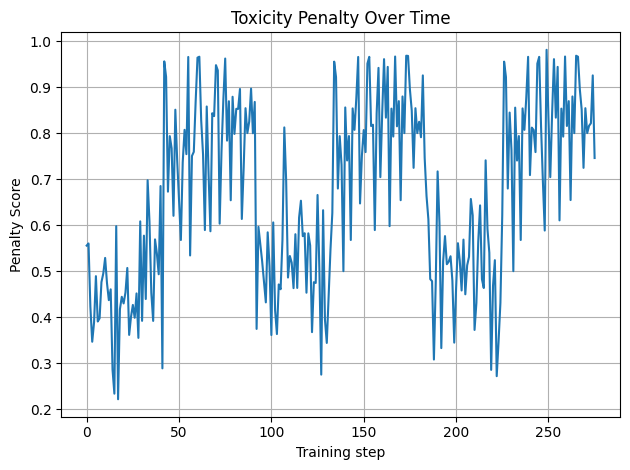

In [43]:
import matplotlib.pyplot as plt
import json

# Save logs to JSON
with open("trainer_log.json", "w", encoding="utf-8") as f:
    json.dump(trainer.state.log_history, f, indent=2)

# ✅ Now read logs back from file
with open("trainer_log.json", "r", encoding="utf-8") as f:
    logs = json.load(f)

# Extract and plot penalty scores
penalties = [log["penalty_score"] for log in logs if "penalty_score" in log]
plt.plot(penalties)
plt.xlabel("Training step")
plt.ylabel("Penalty Score")
plt.title("Toxicity Penalty Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer
)
import torch
import warnings
import matplotlib.pyplot as plt
import json
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_refined",
    report_to="none"
)

# ✅ Custom Trainer with full-batch penalty, lambda warmup, and logging
class ToxicityPenaltyTrainer(Seq2SeqTrainer):
    def __init__(self, *args, lambda_penalty=1.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_penalty = lambda_penalty
        self.tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
        self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
        self.tox_model.eval()
        self.current_step = 0  # For lambda warmup
        self.penalty_log = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        generation_loss = outputs.loss

        sample_input_ids = inputs["input_ids"]
        sample_attention_mask = inputs["attention_mask"]

        self.current_step += 1
        warmup_steps = 500
        current_lambda = min(self.lambda_penalty, self.lambda_penalty * self.current_step / warmup_steps)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                max_length=30,
                num_beams=4,
                do_sample=False,
                early_stopping=True,
                decoder_start_token_id=self.tokenizer.pad_token_id
            )

            decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            tox_inputs = self.tox_tokenizer(decoded_texts, return_tensors="pt", truncation=True, padding=True).to(self.model.device)
            tox_logits = self.tox_model(**tox_inputs).logits
            tox_probs = torch.sigmoid(tox_logits[:, 0])
            penalty = tox_probs.mean()

        self.log({"penalty_score": penalty.item()})
        self.penalty_log.append({
            "penalty_score": penalty.item(),
            "generation_loss": generation_loss.item(),
            "step": self.state.global_step,
            "epoch": self.state.epoch
        })

        penalty_weight = torch.tanh(current_lambda * penalty)
        total_loss = generation_loss + penalty_weight
        return (total_loss, outputs) if return_outputs else total_loss

trainer = ToxicityPenaltyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    lambda_penalty=0.9
)

trainer.train()



  0%|          | 0/93 [00:00<?, ?it/s]

{'penalty_score': 0.7087069153785706, 'epoch': 0}
{'penalty_score': 0.6353474259376526, 'epoch': 0}
{'penalty_score': 0.7844826579093933, 'epoch': 0.03}
{'penalty_score': 0.7458571195602417, 'epoch': 0.03}
{'penalty_score': 0.44866427779197693, 'epoch': 0.06}
{'penalty_score': 0.4931480288505554, 'epoch': 0.06}
{'penalty_score': 0.6301250457763672, 'epoch': 0.1}
{'penalty_score': 0.5489331483840942, 'epoch': 0.1}
{'penalty_score': 0.47519004344940186, 'epoch': 0.13}
{'penalty_score': 0.5105752944946289, 'epoch': 0.13}
{'penalty_score': 0.6139295101165771, 'epoch': 0.16}
{'penalty_score': 0.44990548491477966, 'epoch': 0.16}
{'penalty_score': 0.6534005999565125, 'epoch': 0.19}
{'penalty_score': 0.6393317580223083, 'epoch': 0.19}
{'penalty_score': 0.6505619883537292, 'epoch': 0.22}
{'penalty_score': 0.7399159669876099, 'epoch': 0.22}
{'penalty_score': 0.3056866526603699, 'epoch': 0.25}
{'penalty_score': 0.7775585651397705, 'epoch': 0.25}
{'penalty_score': 0.8608288168907166, 'epoch': 0.29

KeyboardInterrupt: 

BLEU + penalty tradeoff plot skipped: x and y must be the same size


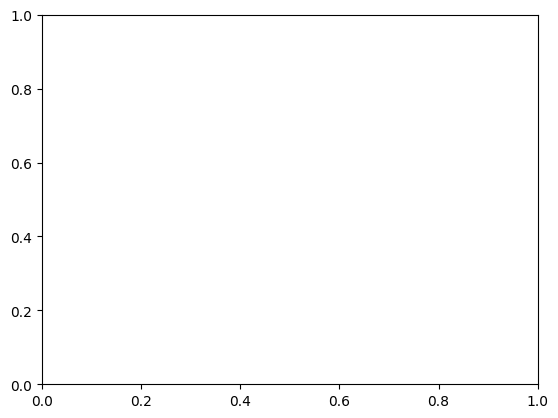

In [47]:
# Save logs to JSON
with open("penalty_log.json", "w", encoding="utf-8") as f:
    json.dump(trainer.penalty_log, f, indent=2)

# Plot BLEU + toxicity tradeoff (example, assumes you also have bleu_scores loaded)
# Example: plot penalty vs fluency
try:
    bleu_scores = [entry.get("bleu", None) for entry in trainer.state.log_history if "bleu" in entry]
    penalty_scores = [entry["penalty_score"] for entry in trainer.penalty_log]
    plt.scatter(bleu_scores[:len(penalty_scores)], penalty_scores)
    plt.xlabel("BLEU Score")
    plt.ylabel("Toxicity Penalty")
    plt.title("Fluency vs. Toxicity Tradeoff")
    plt.grid(True)
    plt.show()
except Exception as e:
    print("BLEU + penalty tradeoff plot skipped:", e)

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Path to your saved model
checkpoint_path = "mt5-detox-en-2/checkpoint-3399"

# Load model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## English Translation

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Load model and tokenizer
model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate_de_to_en(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    translated = model.generate(**inputs)
    return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

translate_de_to_en = translate_de_to_en(formatted_de["input_text"])

In [12]:
input_text = "You are fucking ugly"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Generate detoxified output
output = model.generate(
    **inputs,
    max_length=50,
    num_beams=4,                      # optional: beam search improves fluency
    early_stopping=True,              # stop generation when EOS is reached
    decoder_start_token_id=tokenizer.pad_token_id  # force decoder to start properly
)

# Decode the generated output
decoded = tokenizer.decode(output[0])
print("Detoxified:", decoded)

def generate_detoxified(text):
    input_text = "detoxify (en): " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(model.device)
    output_ids = model.generate(input_ids, max_length=128)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(generate_detoxified("You are the worst piece of garbage."))
print(generate_detoxified("Nobody likes you, idiot."))

Detoxified: <pad> You are ugly</s>
You are the worst piece of garbage.
Nobody likes you.


In [36]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# ✅ Make sure you use the raw (non-tokenized) dataset
# If you accidentally removed input_text/target_text earlier, re-load or cache it

# 🔧 Batch size for faster inference (tune based on your GPU)
BATCH_SIZE = 16

# Collate function for batching text
def collate_fn(batch):
    texts = [ex["input_text"] for ex in batch]
    return tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

# DataLoader
loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Storage for results
detoxified_outputs = []
input_texts = []
reference_texts = []

# Run generation
model.eval()
for i, batch in enumerate(tqdm(loader)):
    batch = {k: v.to(model.device) for k, v in batch.items()}
    outputs = model.generate(
        **batch,
        max_length=50,
        num_beams=4,
        early_stopping=True,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    detoxified_outputs.extend(decoded)

    # Save corresponding original and reference text
    for j in range(len(decoded)):
        example = eval_dataset[i * BATCH_SIZE + j]
        input_texts.append(example["input_text"])
        reference_texts.append(example["target_text"])




























100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


In [26]:
import json

# Save results to a JSON file
output_data = {
    "input_texts": input_texts,
    "reference_texts": reference_texts,
    "detoxified_outputs": detoxified_outputs
}

with open("detoxified_results.json", "w", encoding="utf-8") as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

print("Detoxified texts saved to detoxified_results.json ✅")

Detoxified texts saved to detoxified_results.json ✅


## BLEU Evaluation Score

In [44]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#nltk.download("punkt_tab")
import numpy as np


smooth_fn = SmoothingFunction().method4

bleu_scores = []

for hyp, ref in zip(detoxified_outputs, reference_texts):
    hyp_tokens = nltk.word_tokenize(hyp)
    ref_tokens = nltk.word_tokenize(ref)
    
    score = sentence_bleu(
        [ref_tokens],
        hyp_tokens,
        smoothing_function=smooth_fn
    )
    bleu_scores.append(score)

avg_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {avg_bleu:.4f}")


Average BLEU Score: 0.4798


## Bert-score

In [37]:
from bert_score import score

# Use your lists from earlier
# detoxified_outputs = [...]   # model-generated sentences
# reference_texts = [...]      # ground truth neutral sentences

P, R, F1 = score(detoxified_outputs, reference_texts, lang="en", verbose=True)

# Average scores
print(f"Average BERTScore Precision:  {P.mean():.4f}")
print(f"Average BERTScore Recall:     {R.mean():.4f}")
print(f"Average BERTScore F1:         {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 1.02 seconds, 392.38 sentences/sec
Average BERTScore Precision:  0.9465
Average BERTScore Recall:     0.9485
Average BERTScore F1:         0.9473


## Toxicity Score Evaluation

Original:    detoxify: then all of a sudden i see her , shes now got the big phony tits and everything .
Detoxified:  then all of a sudden i see her, shes now got the big tits and everything.
Toxicity Before: 0.93
Toxicity After:  0.93
--------------------------------------------------
Original:    detoxify: My page should be protected first so that worthless scum like you can't keep vandalizing it.
Detoxified:  My page should be protected first so that worthless like you can't keep it.
Toxicity Before: 0.95
Toxicity After:  0.60
--------------------------------------------------
Original:    detoxify: You made a mistake you ass.
Detoxified:  You made a mistake.
Toxicity Before: 0.97
Toxicity After:  0.00
--------------------------------------------------
Average Toxicity Before: 0.92
Average Toxicity After: 0.43


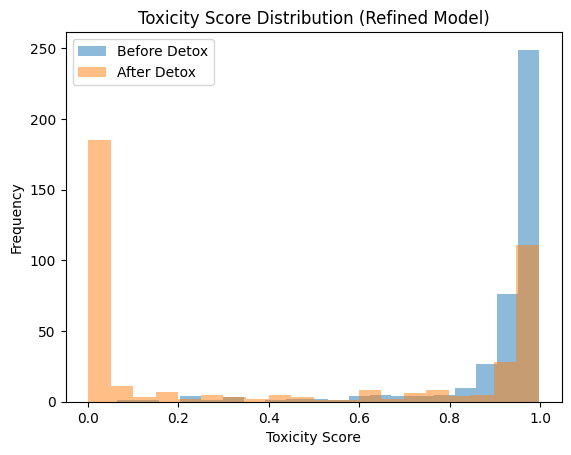

In [45]:
from detoxify import Detoxify

# Load Detoxify model
toxicity_model = Detoxify('unbiased')

# Run toxicity prediction
toxicity_scores = toxicity_model.predict(input_texts)
detoxified_scores = toxicity_model.predict(detoxified_outputs)

# Print sample comparisons
for i in range(3):
    print(f"Original:    {input_texts[i]}")
    print(f"Detoxified:  {detoxified_outputs[i]}")
    print(f"Toxicity Before: {toxicity_scores['toxicity'][i]:.2f}")
    print(f"Toxicity After:  {detoxified_scores['toxicity'][i]:.2f}")
    print("-" * 50)


import numpy as np
import matplotlib.pyplot as plt

# Calculate average toxicity
avg_toxicity_before = np.mean(toxicity_scores['toxicity'])
avg_toxicity_after = np.mean(detoxified_scores['toxicity'])

print(f"Average Toxicity Before: {avg_toxicity_before:.2f}")
print(f"Average Toxicity After: {avg_toxicity_after:.2f}")

# Plotting the distributions
plt.hist(toxicity_scores['toxicity'], bins=20, alpha=0.5, label='Before Detox')
plt.hist(detoxified_scores['toxicity'], bins=20, alpha=0.5, label='After Detox')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.title('Toxicity Score Distribution (Refined Model)')
plt.legend()
plt.show()


In [29]:
from scipy.stats import ttest_rel

# Example: compare two arrays of toxicity scores
before = np.array(toxicity_scores['toxicity'])
after = np.array(detoxified_scores['toxicity'])

t_stat, p_value = ttest_rel(before, after)
print(f"t = {t_stat:.3f}, p = {p_value:.5f}")

t = 30.232, p = 0.00000
